In [1]:
import torch
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader, IterableDataset, TensorDataset
import torchvision.transforms as T
import torch.nn.functional as F
# from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from tqdm import tqdm
from datetime import datetime
from torch.amp import autocast
import math
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
# req torch, torchvision, einops, tqdm, ema_pytorch, accelerate
from IPython.display import display
from einops import rearrange, reduce, repeat
import glob
from ema_pytorch import EMA
from scipy.optimize import linear_sum_assignment
from accelerate import Accelerator
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple

import os
CWD = os.getcwd()

# Device stuff
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Remember to use {device} device from here on")
print(os.chdir("../"))
# %cd /home/physics/phuqza/E9/DDPM-HL-LHC/
from DDPMLHC.config import *
from DDPMLHC.calculate_quantities import *
from DDPMLHC.data_loading import *
from DDPMLHC.generate_plots.overlaid_1d import create_overlay_plots
from DDPMLHC.generate_plots.bmap import save_to_bmap
from DDPMLHC.generate_plots.histograms_1d import *

BMAP_SQUARE_SIDE_LENGTH = 16

# Some functions from denoising_diffusion_pytorch that are required but couldn't import
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


/home/physics/phuqza/E9/DDPM-HL-LHC/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU Device: NVIDIA RTX A4000
Number of GPUs: 1
Remember to use cuda device from here on
None


In [2]:
def show_tensor_images(tensor_images, scale_factor=8):
    to_pil = T.ToPILImage()
    pil_images = [to_pil(image) for image in tensor_images]

    for img in pil_images:
        # Upscale the image
        upscaled_img = img.resize(
            (img.width * scale_factor, img.height * scale_factor), 
            Image.NEAREST  # or Image.BOX for smoother results
        )
        display(upscaled_img)


In [3]:
# Base code for training generated by Claude 3.5. Since modified for our purposes.
## Custom reimplementation of Trainer from DDPM
## Avoid subclassing because we do not want to pass in literal files

def load_and_train(
    diffusion,
    dataloader,
    num_epochs,
    device,
    save_dir,
    lr=1e-4
):
    os.makedirs(save_dir, exist_ok=True)
    loss_array = []
    # Get last epoch number
    checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
    last_epoch = 0
    if checkpoint_files:
        epoch_numbers = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
                epoch_numbers.append(epoch_num)
            except:
                continue
        last_epoch = max(epoch_numbers) if epoch_numbers else 0

    # Load checkpoint if exists
    if last_epoch > 0:
        checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
        checkpoint_file = glob.glob(checkpoint_pattern)[0]
        print(f"Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        diffusion.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Starting fresh training")

    optimizer = optim.Adam(diffusion.parameters(), lr=lr)

    for epoch in range(last_epoch, last_epoch + num_epochs):
        print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

        running_loss = 0.0
        for i, images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (i + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.7f}'})
        loss_array.append(avg_loss)
        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.7f}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': diffusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')
    # Return array of final losses for plotting
    return loss_array


In [4]:
MAX_DATA_ROWS = None
bins=BMAP_SQUARE_SIDE_LENGTH

# === Read in data
print("0 :: Loading original data")
tt = np.genfromtxt(
    TT_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
pu = np.genfromtxt(
    PILEUP_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
tt = EventSelector(tt)
pu = EventSelector(pu)
print("FINISHED loading data\n")

# Ground truth ttbar jets
NG_jet = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0)
# Second one to randomly generate and return pile-up events ONLY
## Will use np.random.randint to generate NoisyGenerator.mu and then call next
NG_pu = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0, pu_only=True)

0 :: Loading original data
FINISHED loading data



In [5]:
model = Unet(
    dim=64,                  # Base dimensionality of feature maps
    dim_mults=(1, 2, 4, 8),  # Multipliers for feature dimensions at each level
    channels=1,              # E.g. 3 for RGB
).to(device)

# diffusion = GaussianDiffusion(
#     model = model,
#     image_size = 16,  # Size of your images (ensure your images are square)
#     timesteps = 1000,  # Number of diffusion steps
#     objective = "pred_x0",
# ).to(device)

diffusion = PUDiffusion(
    model = model,
    puNG = NG_pu,
    jet_ng= NG_jet,
    image_size = bins,  # Size of your images (ensure your images are square)
    timesteps = 200,  # Number of diffusion steps
    objective = "pred_x0",
    sampling_timesteps = None
).to(device)

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 92.87it/s] 

final timestep:  200


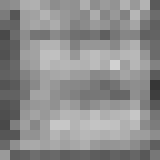

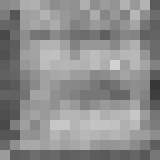

In [6]:
# Generate samples
batch_size = 2
# NG_jet.reset()
# NG_pu.reset()
sampled_images = diffusion.sample(batch_size=batch_size)
show_tensor_images(sampled_images, scale_factor=10)
# pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# show_tensor_images(pats, scale_factor=10)

In [7]:
# this one is to be passed into DataLoader for training
train_batch_size = 200
ng_for_dataloader = NGenForDataloader(NG_jet)
dataloader = DataLoader(ng_for_dataloader, batch_size=train_batch_size, num_workers=2, shuffle = True, pin_memory = True)
save_dir = f"{CWD}/data/ML/4-PUnoise"
num_epochs = 0

xd = load_and_train(diffusion, dataloader, num_epochs=num_epochs, device=device, save_dir=save_dir, lr=1e-5)

print("Finished training")

/tmp/ipykernel_133749/1745678882.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=device)


Loading checkpoint: /home/physics/phuqza/E9/DDPM-HL-LHC/data/ML/4-PUnoise/checkpoint_epoch_502_loss_0.0000033.pth
Finished training


In [8]:
# Set model to evaluation mode
model.eval()
diffusion.eval()

PUDiffusion(
  (model): Unet(
    (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (block2): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inpla

['data', 'run_unbinning.sh', 'DDPMLHC', 'run.sh', 'venv', '.gitignore', 'README.md', 'requirements.txt', 'LICENSE', 'ML', '__init__.py', '.git']
['./data/ML/second/checkpoint_epoch_177_loss_7.3379.pth', './data/ML/second/checkpoint_epoch_79_loss_25.5938.pth', './data/ML/second/checkpoint_epoch_11_loss_157.9835.pth', './data/ML/second/checkpoint_epoch_37_loss_55.4672.pth', './data/ML/second/checkpoint_epoch_24_loss_70.7525.pth', './data/ML/second/checkpoint_epoch_200_loss_3.5882.pth', './data/ML/second/checkpoint_epoch_23_loss_77.8002.pth', './data/ML/second/checkpoint_epoch_166_loss_6.6058.pth', './data/ML/second/checkpoint_epoch_163_loss_6.7927.pth', './data/ML/second/checkpoint_epoch_229_loss_2.7606.pth', './data/ML/second/checkpoint_epoch_208_loss_3.4767.pth', './data/ML/second/checkpoint_epoch_53_loss_30.0944.pth', './data/ML/second/checkpoint_epoch_8_loss_2716.2565.pth', './data/ML/second/checkpoint_epoch_178_loss_41.8503.pth', './data/ML/second/checkpoint_epoch_10_loss_210.9955.p

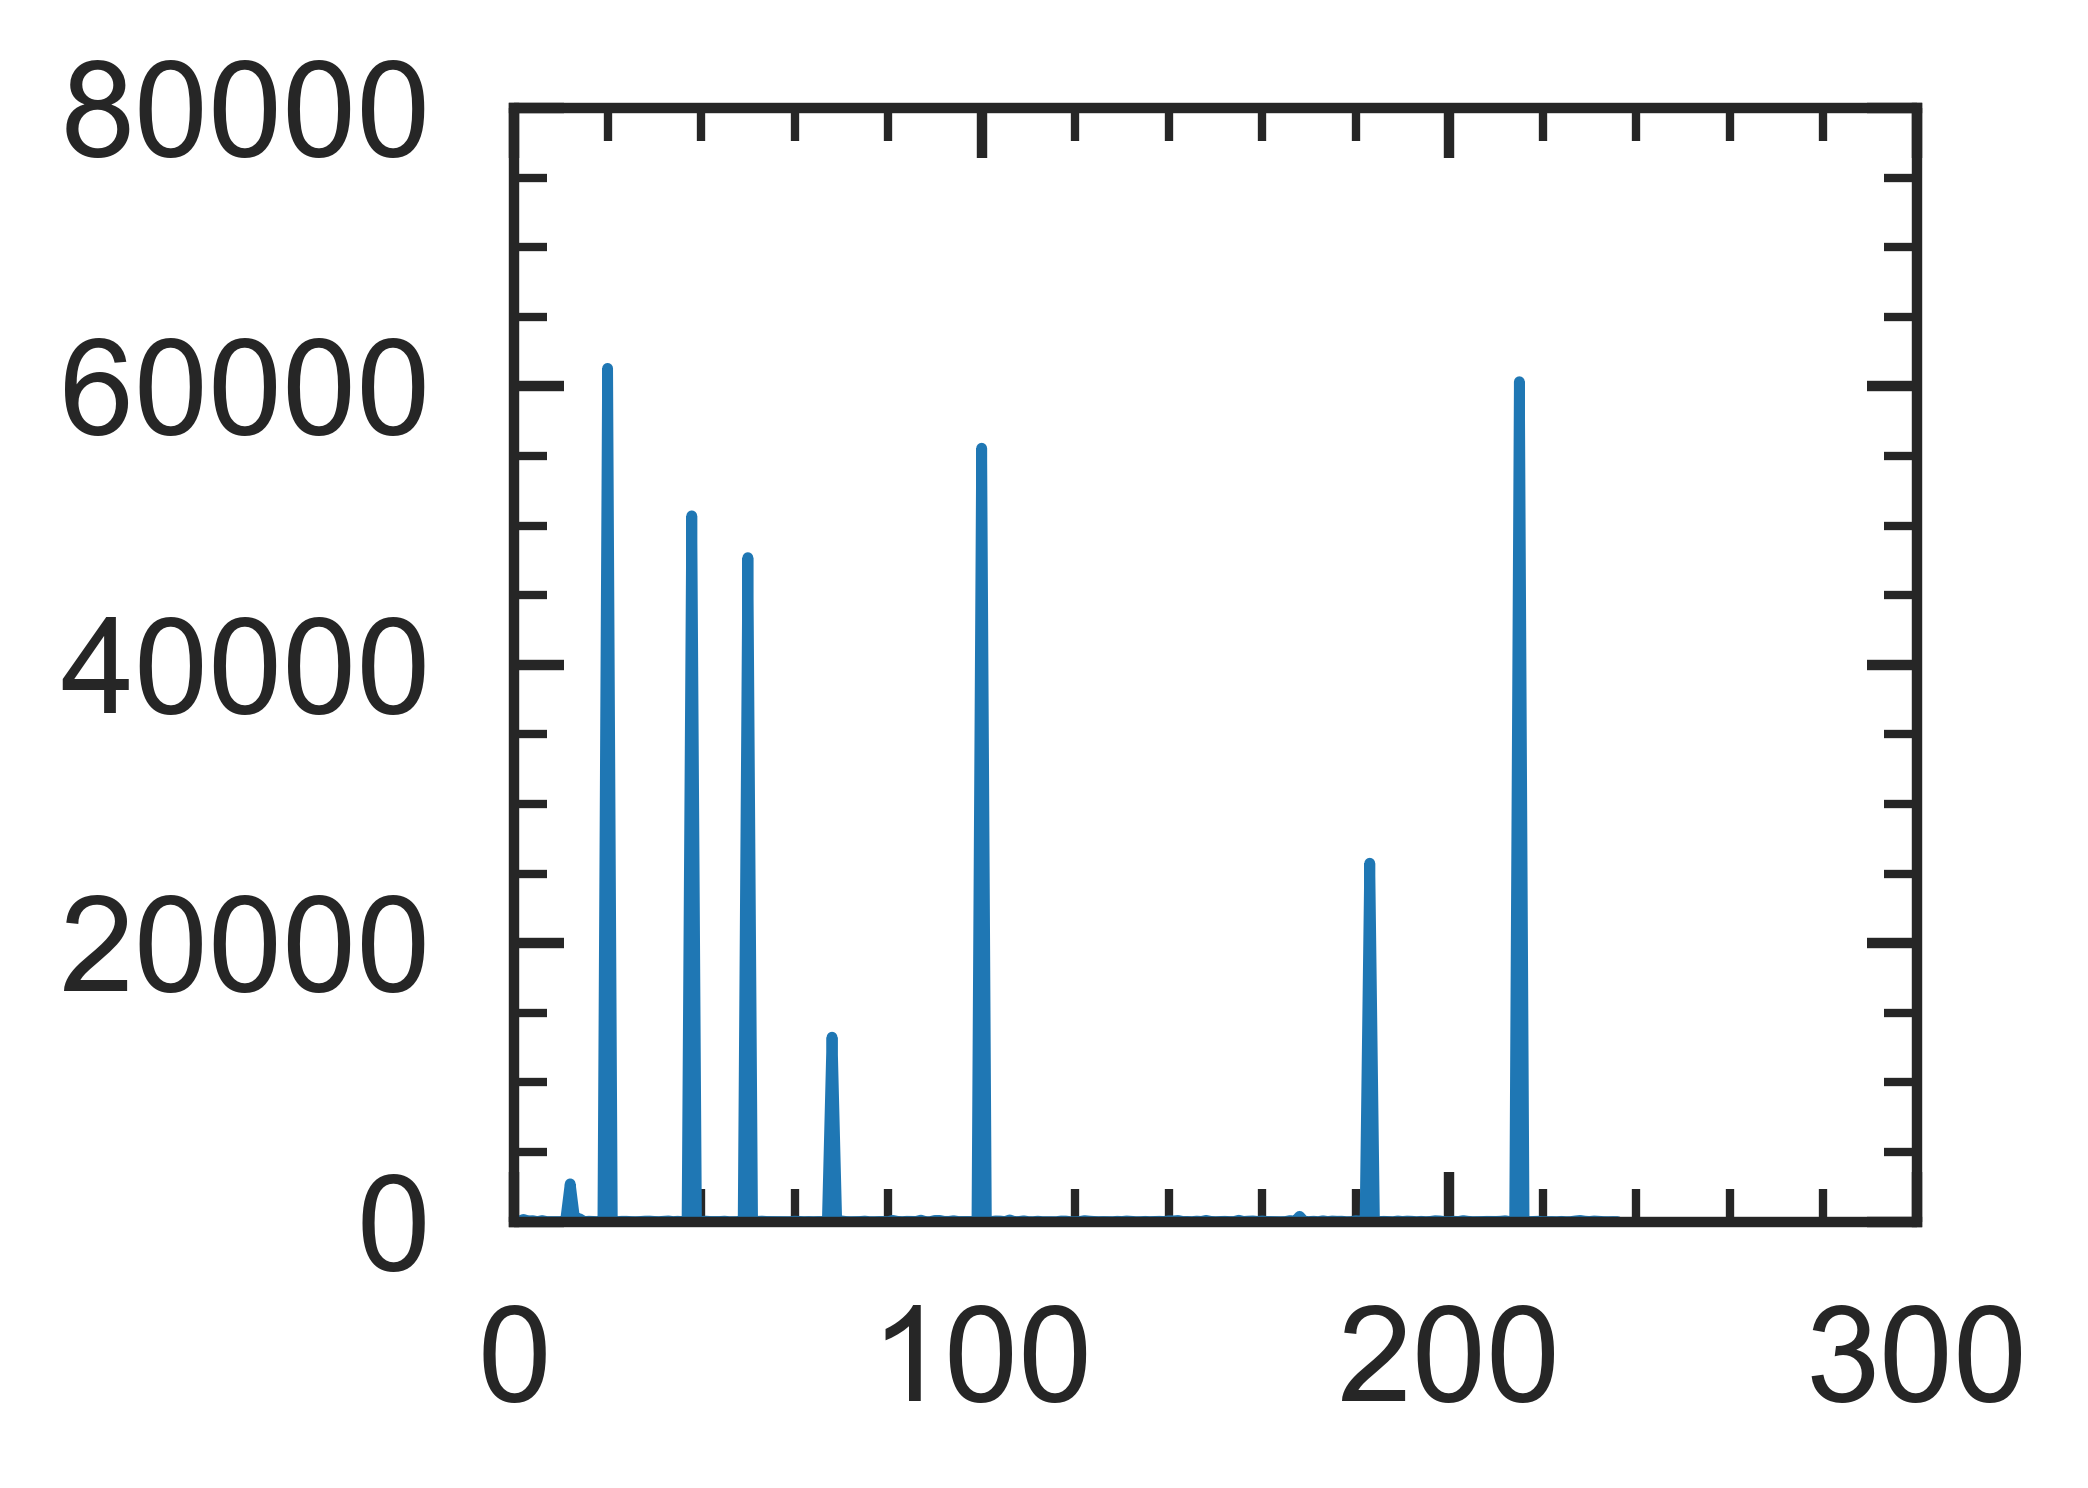

In [9]:
MPL_GLOBAL_PARAMS = {
    'text.usetex' : False, # use latex text
    'text.latex.preamble' : r'\usepackage{type1cm}\usepackage{braket}\usepackage{amssymb}\usepackage{amsmath}\usepackage{txfonts}', # latex packages
    'font.size' : 24,
    'figure.dpi' : 600,
    'figure.figsize' : (4, 3),
    'figure.autolayout' : True, # tight layout (True) or not (False)
    'axes.labelpad' : 5,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
    'axes.grid' : False,
    'axes.autolimit_mode' : 'round_numbers', # set axis limits by rounding min/max values
    # 'axes.autolimit_mode' : 'data', # set axis limits as min/max values
    'xtick.major.pad' : 10,
    'ytick.major.pad' : 10,
    'xtick.labelsize': label_fontsize,
    'ytick.labelsize': label_fontsize,
    'lines.linewidth' : 1.3,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'xtick.top' : True,
    'ytick.right' : True,
    'xtick.minor.visible' : True,
    'ytick.minor.visible' : True,
    'axes.prop_cycle': cycler(color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']*3),
    'legend.framealpha': None
  }
mpl.rcParams.update(MPL_GLOBAL_PARAMS)

import glob
import re
import os

def get_losses_from_checkpoints(checkpoint_dir='./data/ML/second'):
    # Get absolute path to checkpoint directory
    print(os.listdir("."))
    checkpoint_pattern = os.path.join(checkpoint_dir, 'checkpoint_epoch_*_loss_*.pth')
    
    # Get all matching files
    files = glob.glob(checkpoint_pattern)
    print(files)
    losses = []
    pattern = r'loss_([\d.]+)\.pth'
    
    for file in files:
        match = re.search(pattern, file)
        if match:
            loss = float(match.group(1))
            losses.append(loss)
    
    return len(files), losses

# Usage:
num_files, losses = get_losses_from_checkpoints()  
print(f"Number of checkpoint files: {num_files}")
print(f"Losses: {losses}")

fig = plt.figure()
# num,losses = get_losses_from_checkpoints()
plt.plot(list(range(num_files)),losses)
plt.show()

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 98.84it/s] 

final timestep:  200


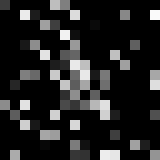

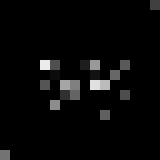

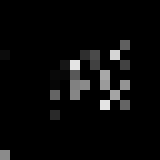

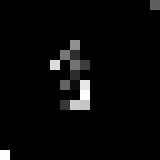

In [10]:
sampled_images = diffusion.sample(batch_size=4)
show_tensor_images(sampled_images * NG_jet.max_energy, scale_factor=10)

70901


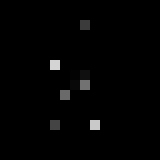

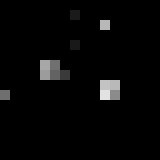

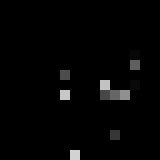

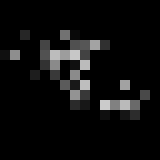

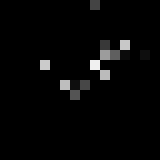

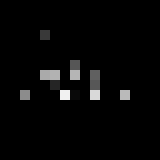

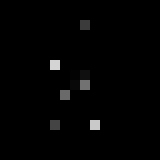

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   9.2704,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0

In [11]:
print(len(ng_for_dataloader))
pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
# print(ng_for_dataloader[0])
ng_for_dataloader_unscaled = [i * NG_jet.max_energy for i in pats]
# show_tensor_images(ng_for_dataloader_unscaled, scale_factor=10)
# print(ng_for_dataloader_unscaled[0])

In [12]:
class OutData():
    def __init__(self, diffusion, NG_jet, num_jets_to_process, bins=BMAP_SQUARE_SIDE_LENGTH):
        self.diffusion = diffusion
        self.NG_jet = NG_jet
        self.num_jets = num_jets_to_process
        self.bins = bins
    
    def _calculate_event_level(self):
        print(f"Generating {self.num_jets} jets...")
        
        sampled_images = diffusion.sample(batch_size=self.num_jets)
        show_tensor_images(sampled_images[:5] * NG_jet.max_energy, scale_factor=10)
        # print(len(sampled_images))
        # print(sampled_images[0])
        rescaled = sampled_images * self.NG_jet.max_energy
        # print(len(rescaled))
        # print(rescaled[0])
        rescaled = rescaled.cpu().numpy()  # PyTorch to numpy
        
        # Remove channel dimension if exists
        print(f"rescaled.shape {rescaled.shape}")
        if len(rescaled.shape) == 4:  # (batch, channel, height, width)
            rescaled = rescaled.squeeze(1)
        print(f"rescaled.shape {rescaled.shape}")
        
        combined = []
        for idx, grid in enumerate(rescaled):
            NG_jet.select_jet(idx)
            axis = NG_jet.jet_axis
            # if idx == 0:
            #     print(f"grid.shape {grid.shape}")
            
            enes, detas, dphis = grid_to_ene_deta_dphi(grid, N=self.bins)
            detas, dphis = decentre(axis, detas, dphis)
            pxs, pys, pzs = deta_dphi_to_momenta(enes, detas, dphis)
            event_quantities = particle_momenta_to_event_level(enes, pxs, pys, pzs)
            event_mass, event_px, event_py, event_pz, event_eta, event_phi, event_pT = event_quantities
            
            event_level = np.array([
                idx,
                event_px,
                event_py,
                event_pz,
                event_eta,
                event_phi,
                event_mass,
                event_pT,
            ])
            
            combined.append(np.copy(event_level))
                
        all_data = np.vstack(combined)
        return all_data
    
    def save_event_level(self, output_folder=f"{CWD}/data/4-reconstruction", output_filename=None):
        if output_filename is None:
            output_filename = f"reconstructed_mu{self.diffusion.mu}_event_level_from_grid{self.bins}.csv"
        output_path = f"{output_folder}/{output_filename}"
        
        data = self._calculate_event_level()
        np.savetxt(
            output_path,
            data,
            delimiter=",",
            header="event_id,px,py,pz,eta,phi,mass,p_T",
            comments="",
            fmt="%i,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f"
        )

        return output_path

In [ ]:
output_folder=f"{CWD}/data/4-reconstruction"
output_filename = f"reconstructed_mu{diffusion.mu}_event_level_from_grid{BMAP_SQUARE_SIDE_LENGTH}.csv"

OD = OutData(diffusion, NG_jet, 8000)
output_path = OD.save_event_level(output_folder=output_folder, output_filename=output_filename)

Generating 10000 jets...


sampling loop time step:  88%|████████▊ | 176/200 [03:46<00:30,  1.29s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 15.60 GiB of which 444.12 MiB is free. Including non-PyTorch memory, this process has 15.13 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 698.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Doing mu = 200...
Final idx (#events - 1):  999.0
Plotting single histograms...
Plotting combined histogram...
Done mu = 200.



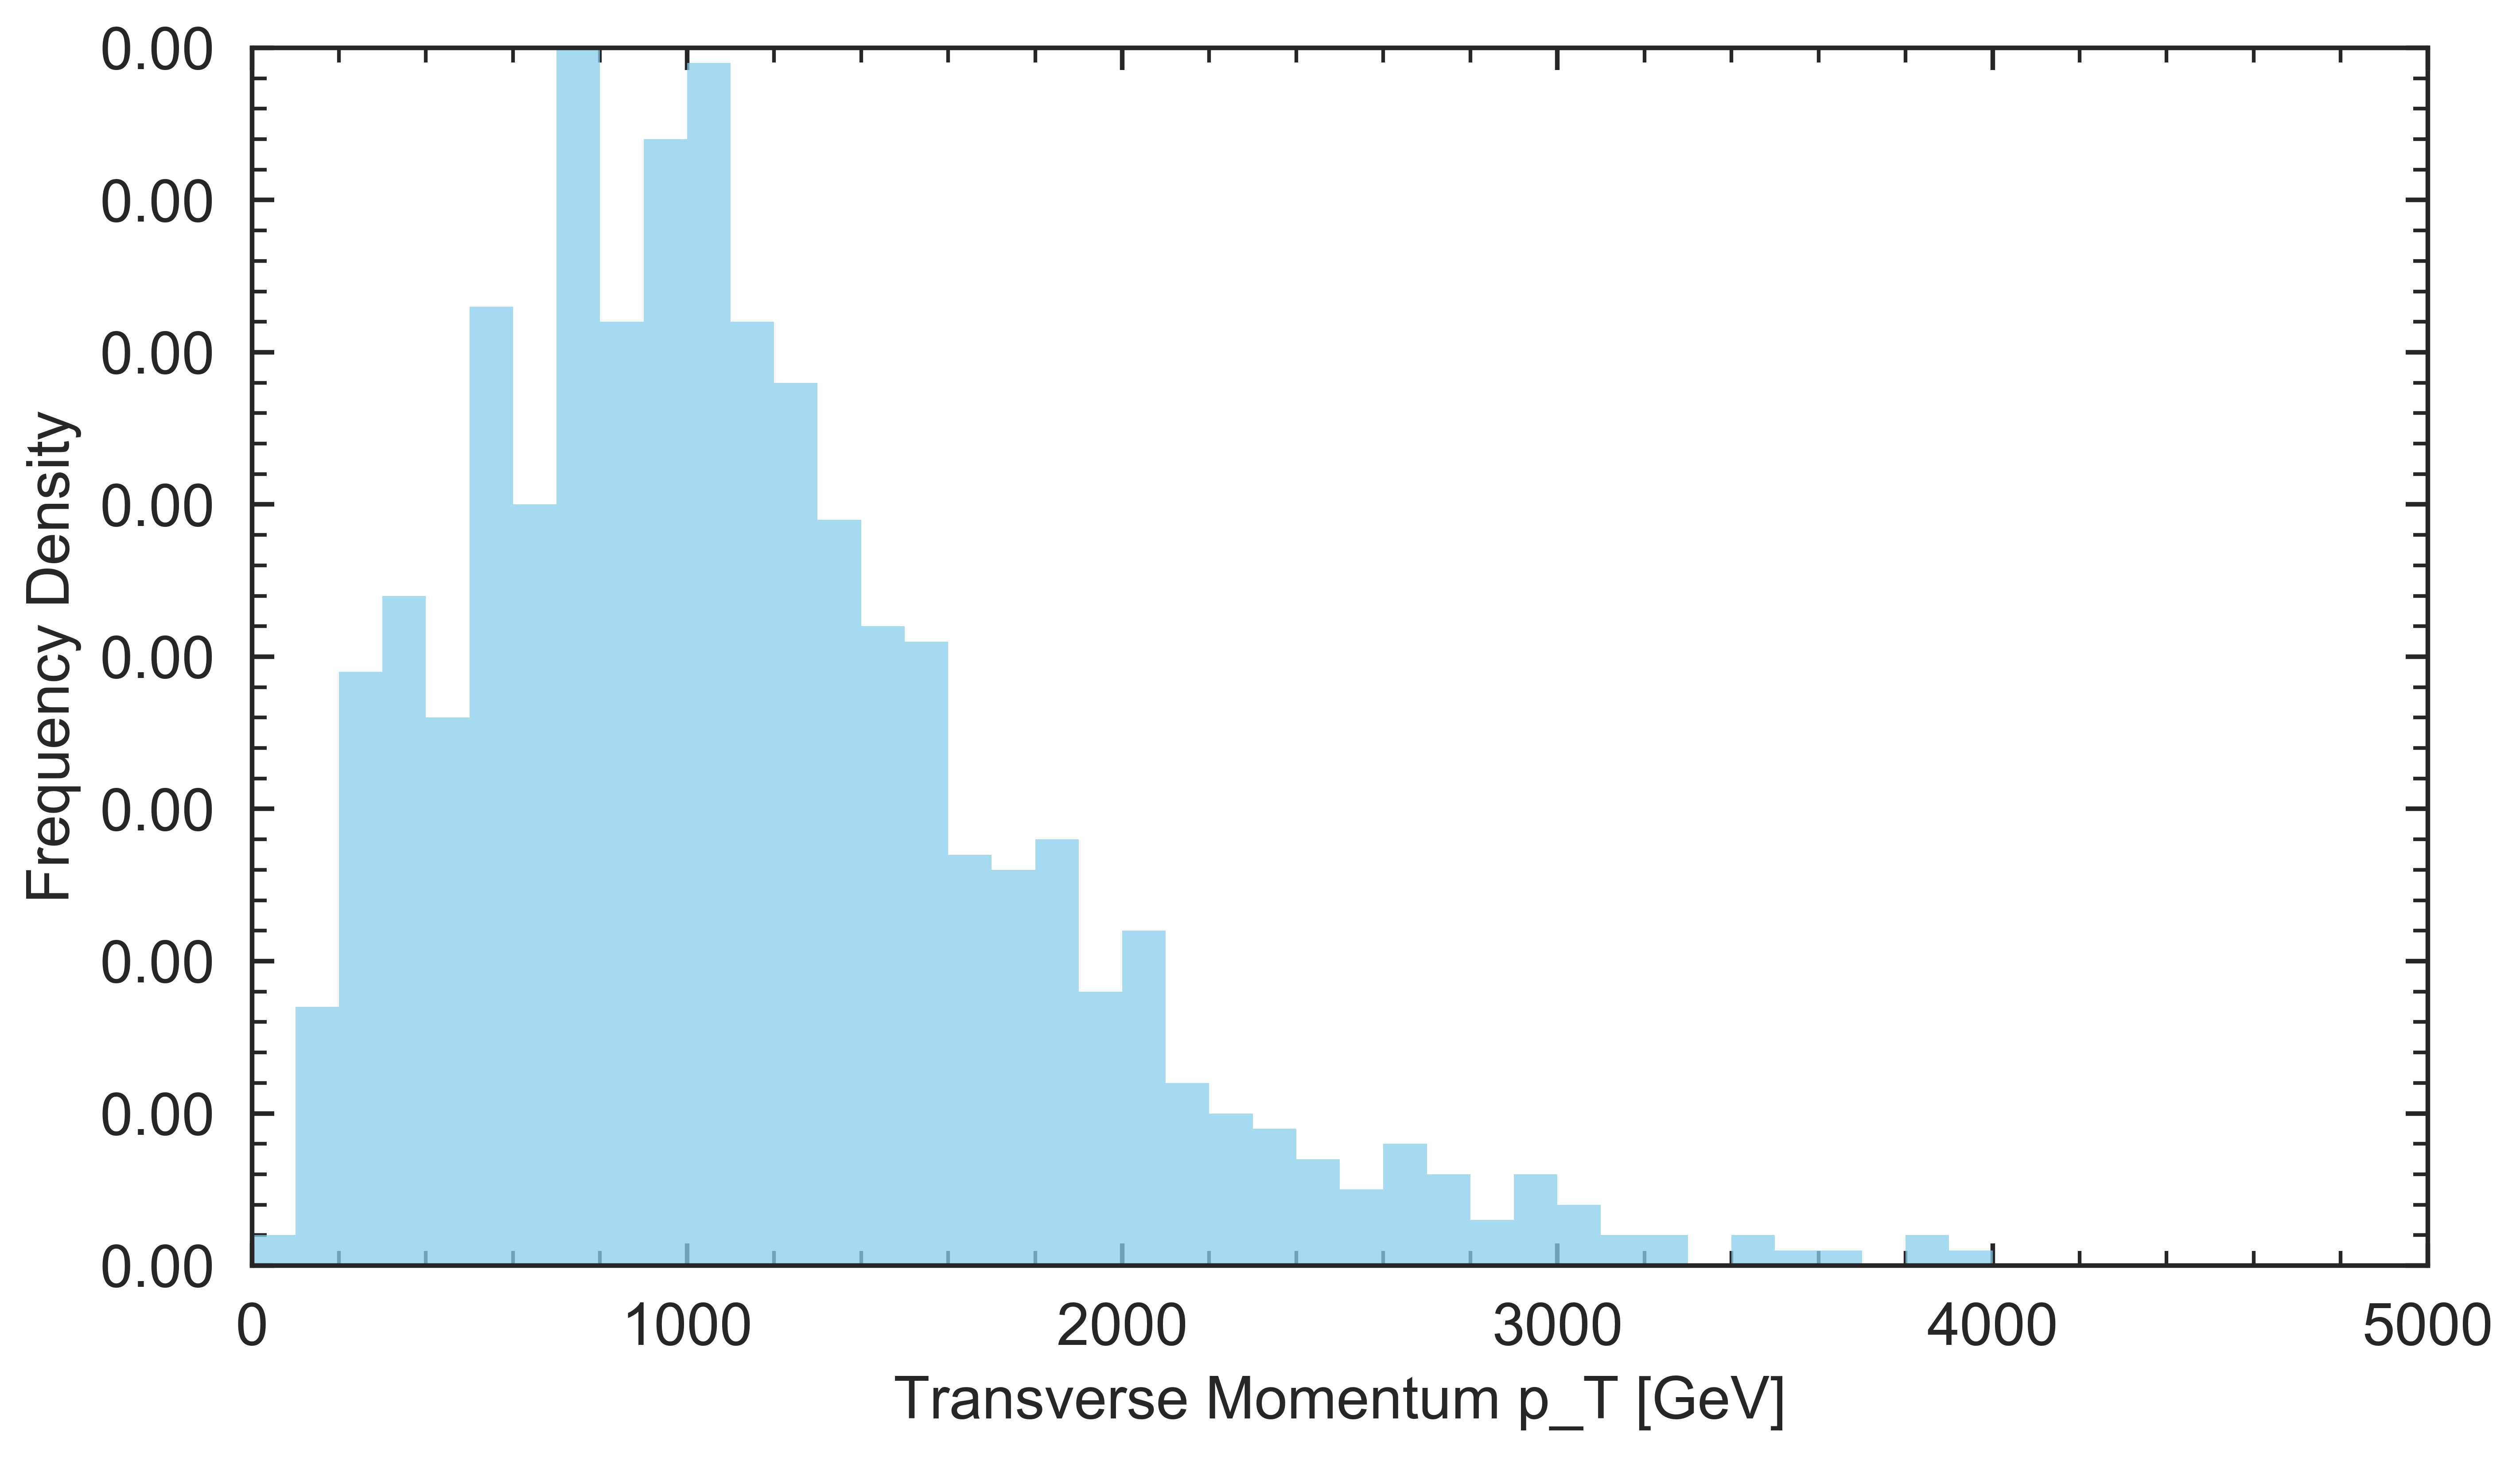

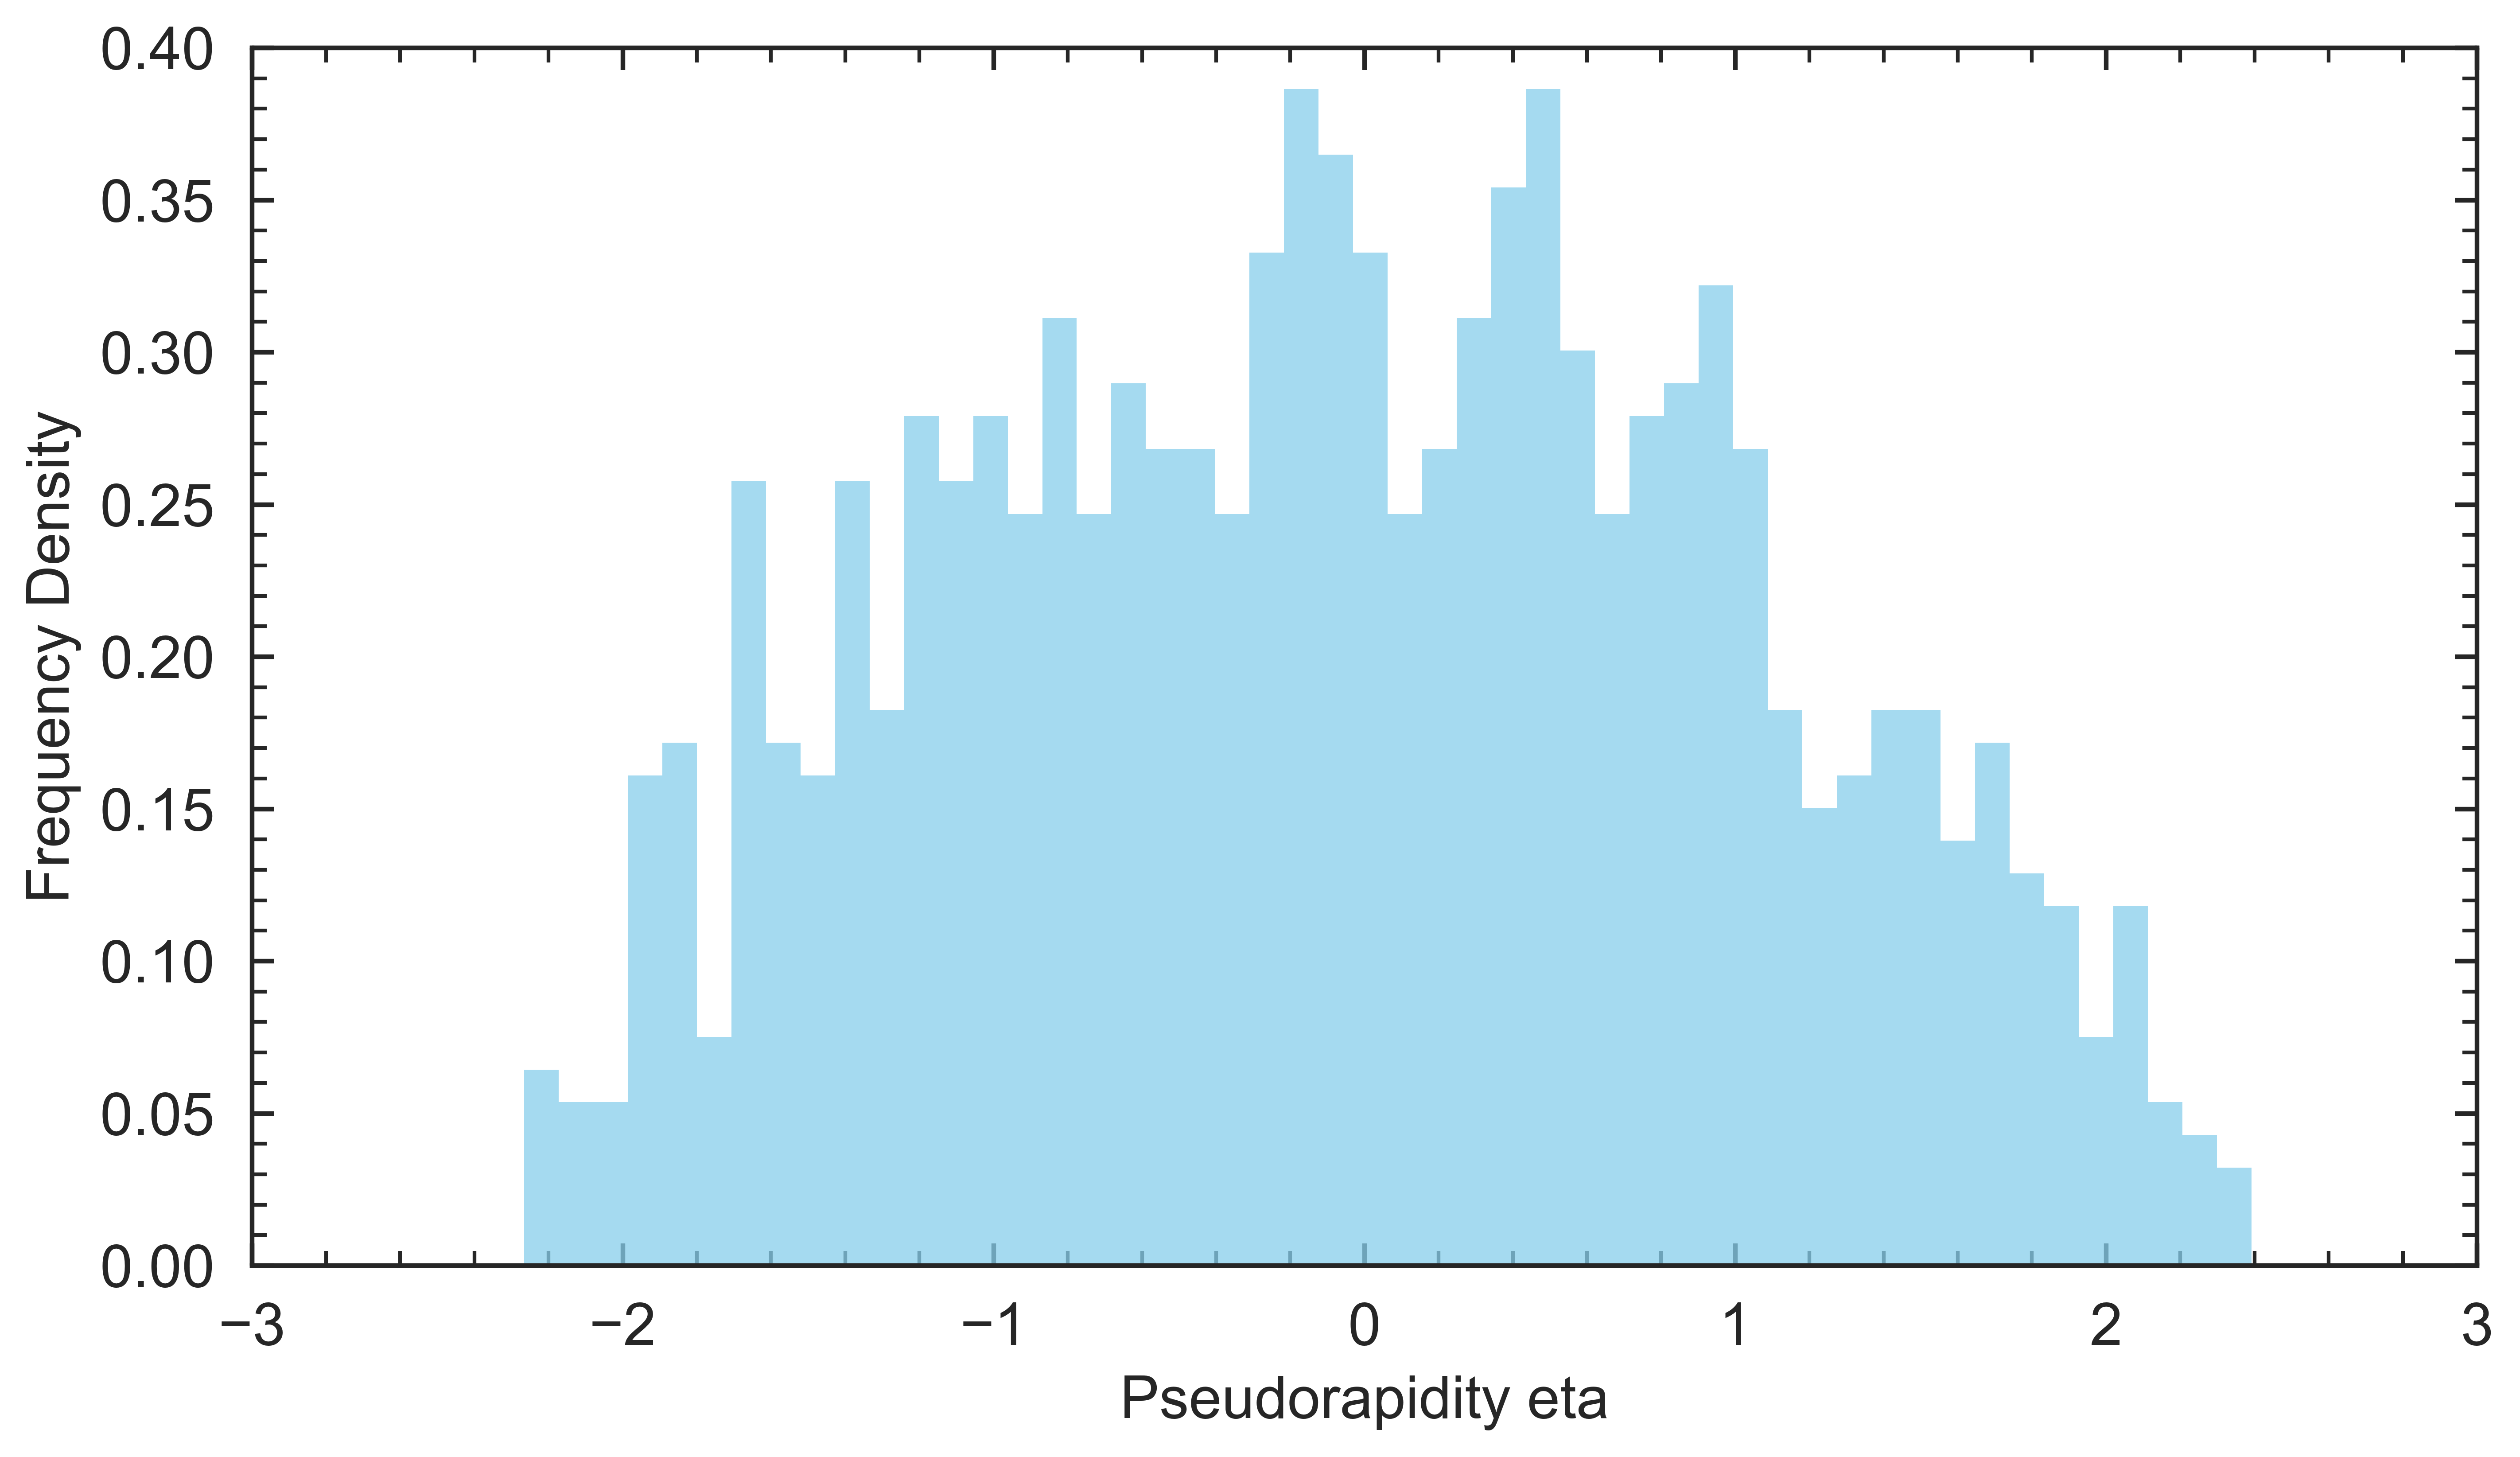

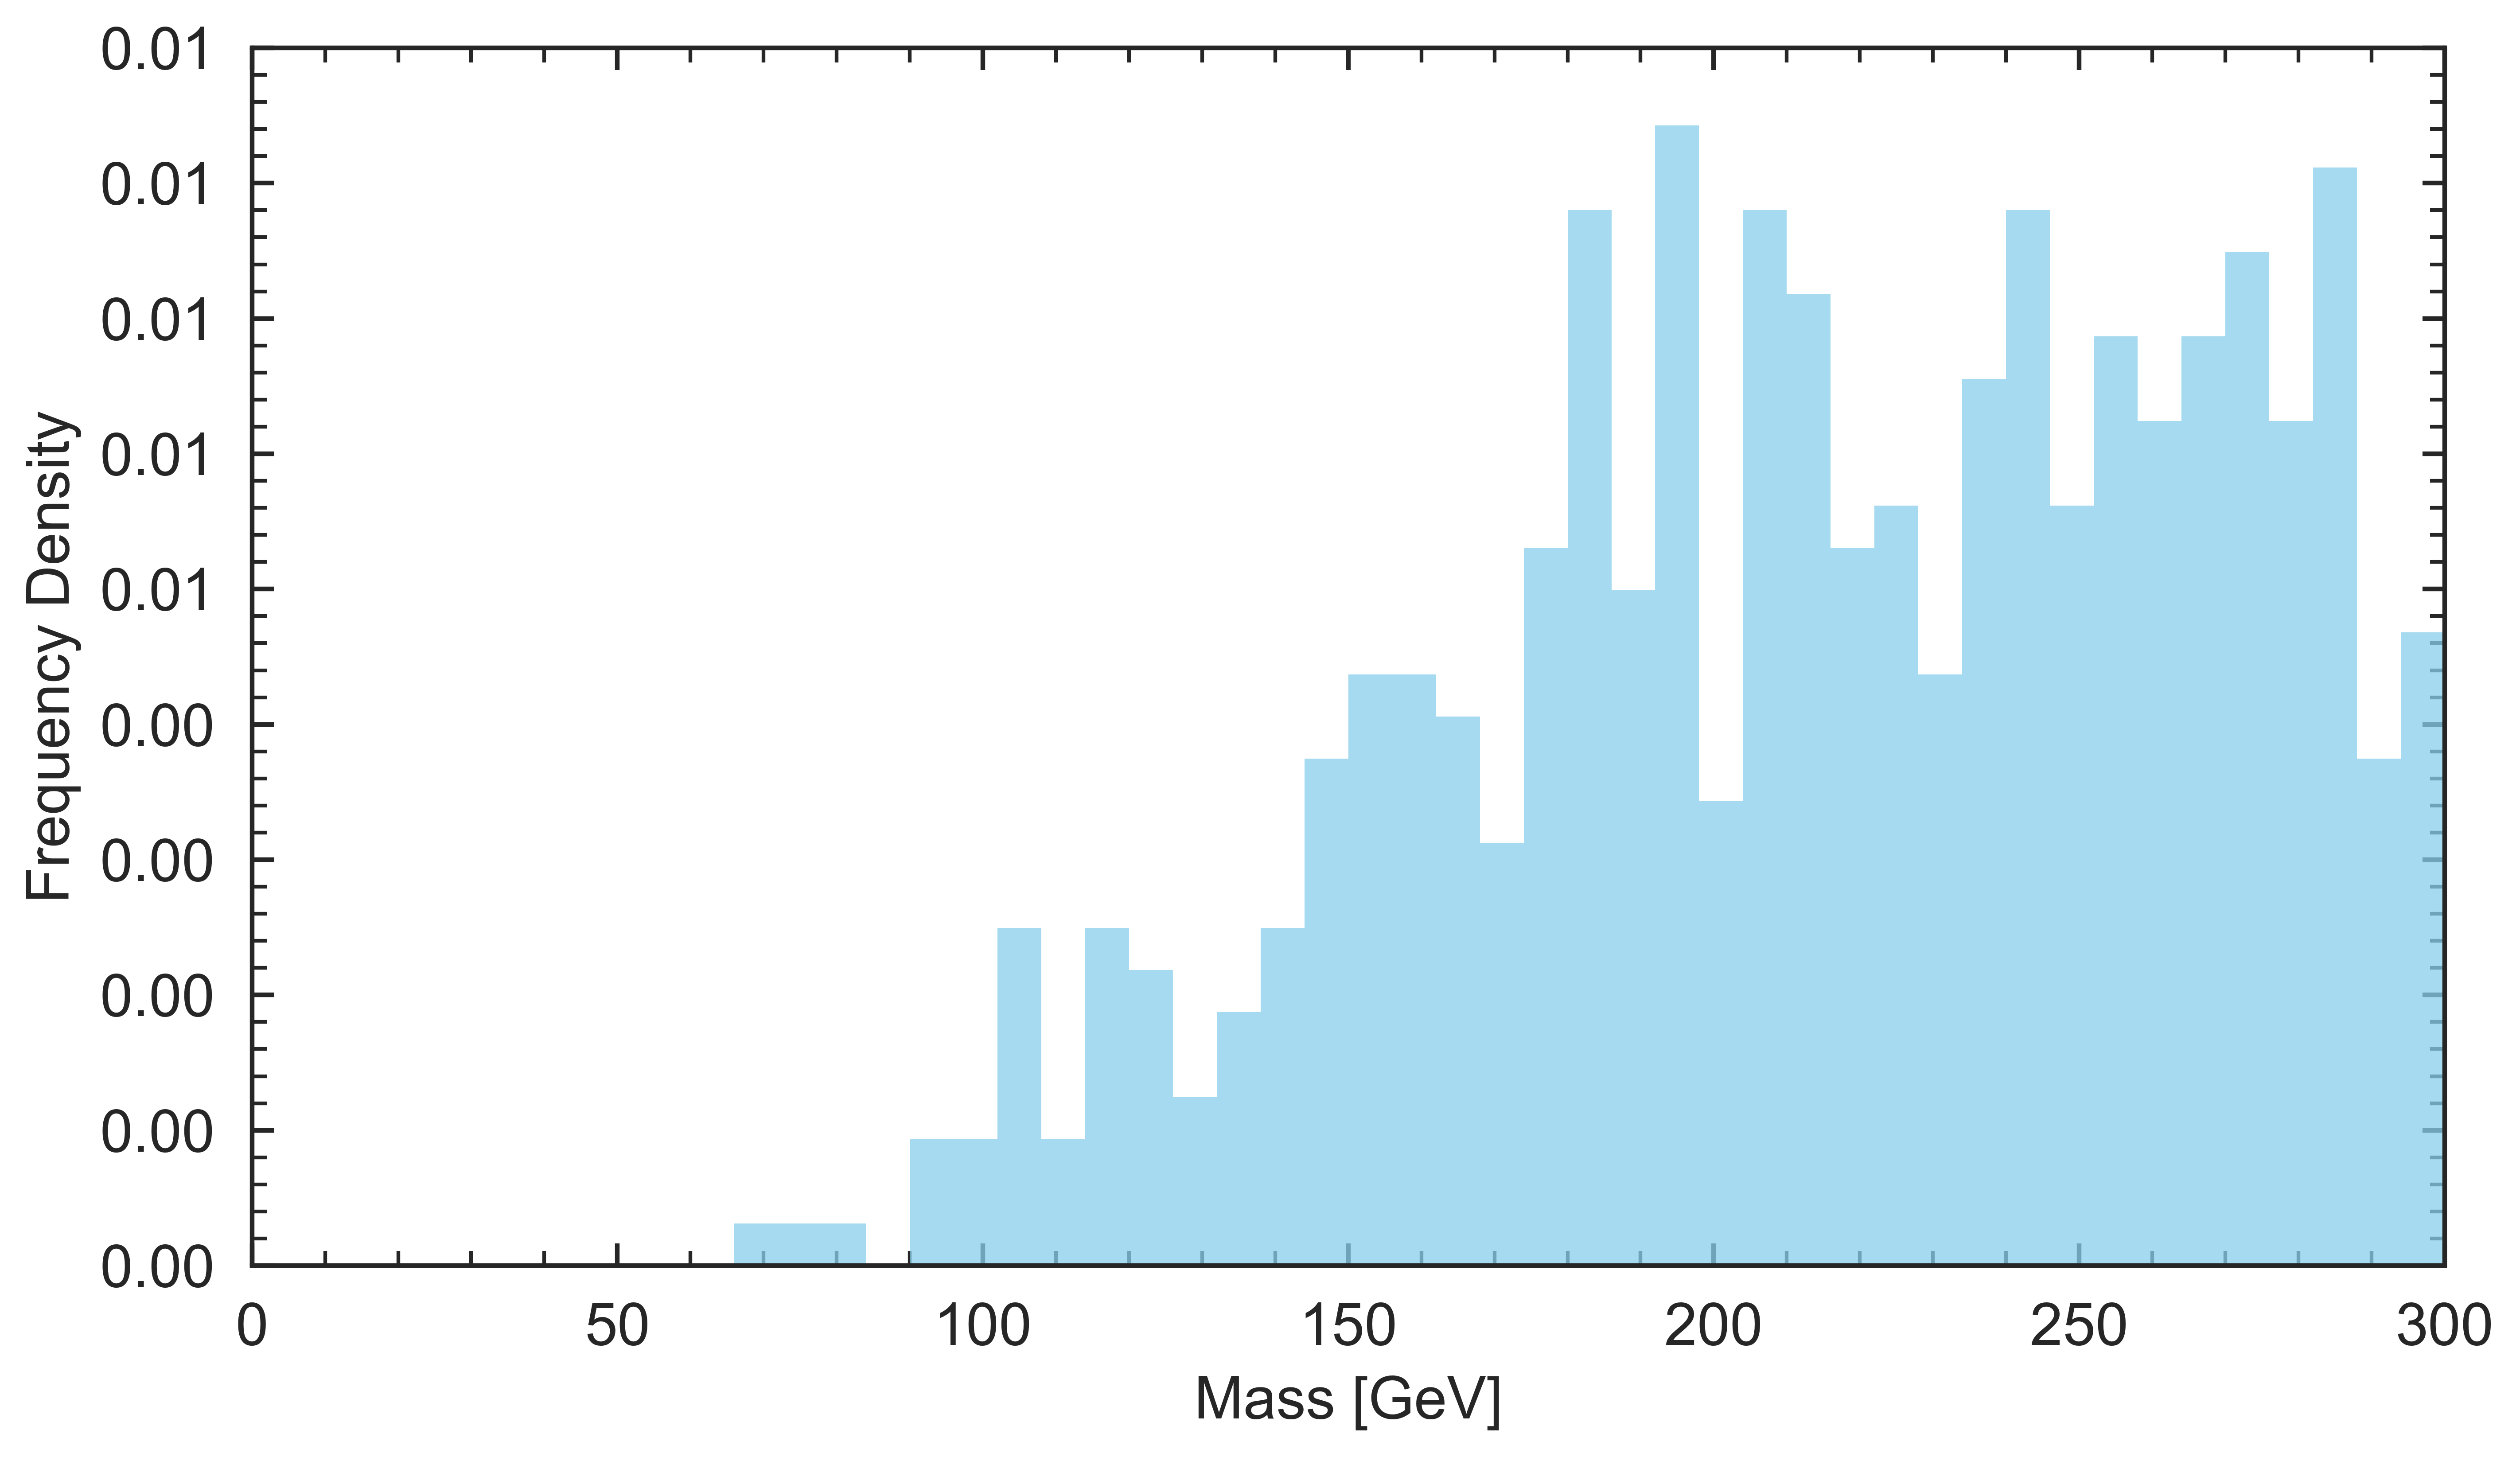

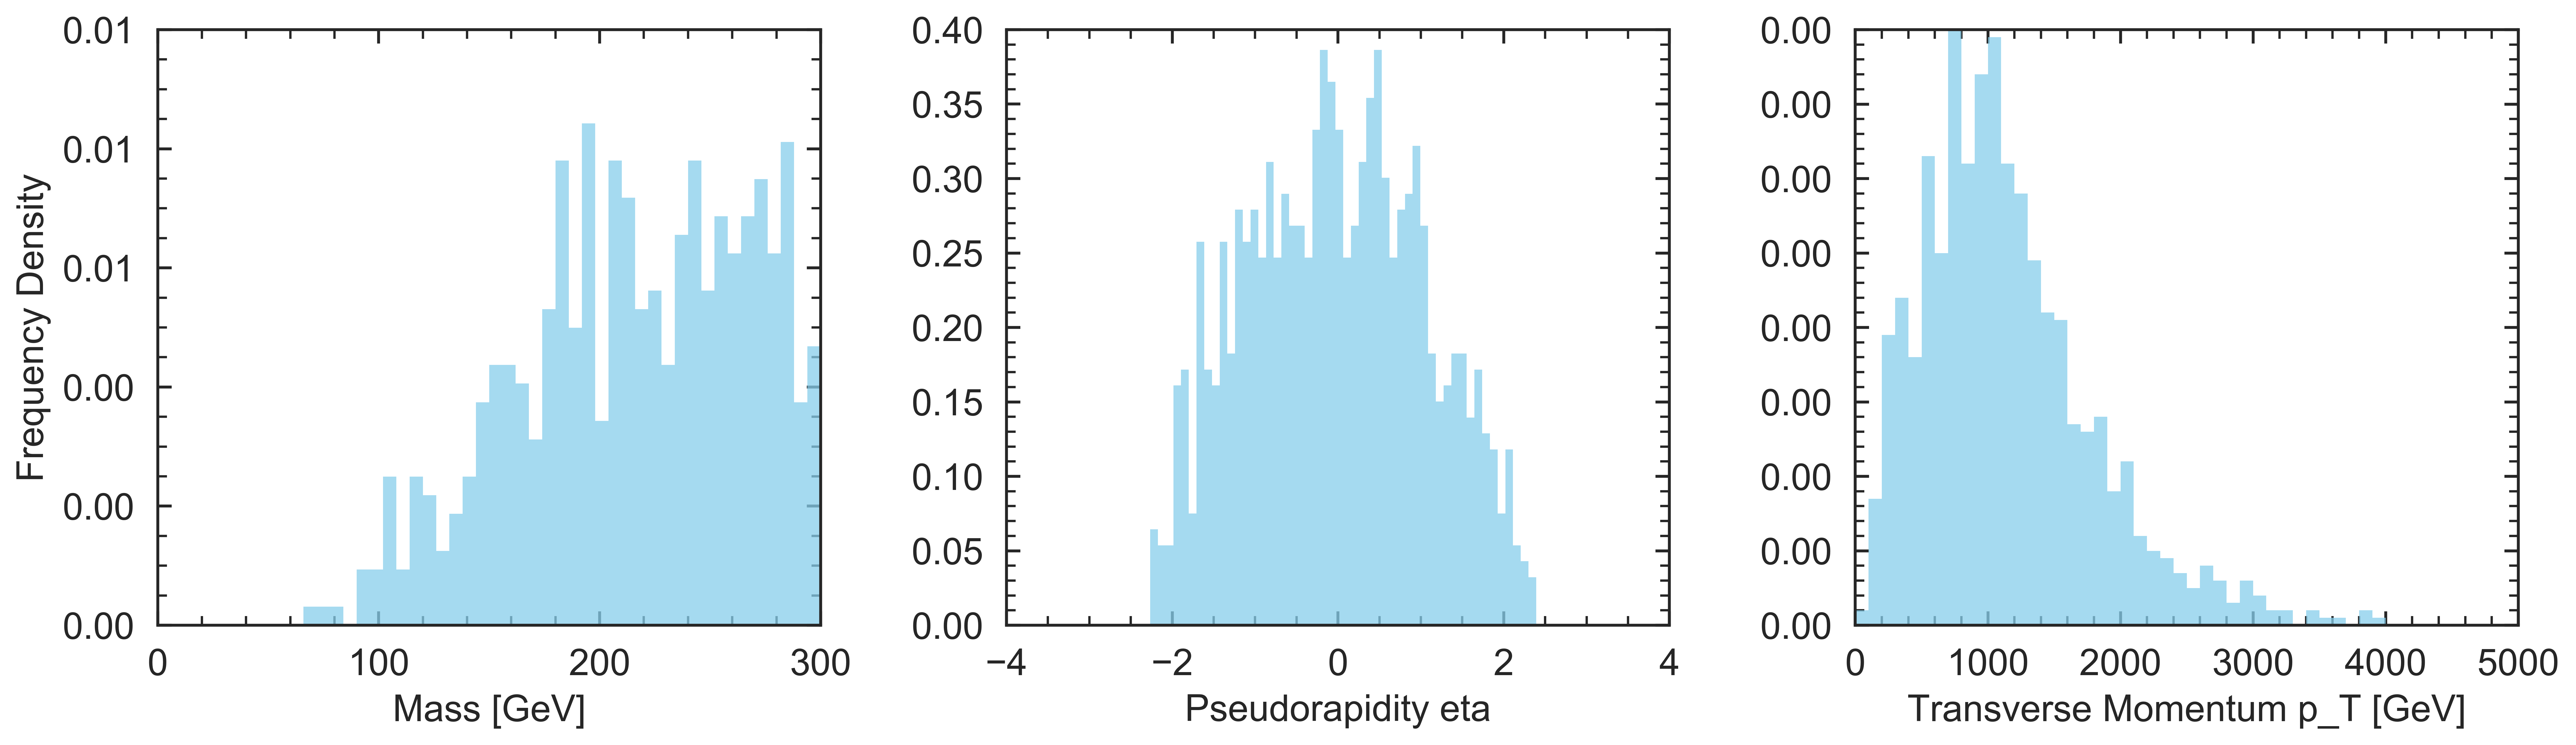

In [17]:
BMAP_SQUARE_SIDE_LENGTH = 16
from DDPMLHC.generate_plots.histograms_1d import plot_1d_histograms
plot_1d_histograms(diffusion.mu, event_stats_path=output_path, output_path=f"{output_folder}/grid{BMAP_SQUARE_SIDE_LENGTH}")

In [15]:
# # Data post-processing
# mu = 200
# output_folder = f"{CWD}/data/3-grid"
# output_filename = f"noisy_mu{mu}_event_level_from_grid{bins}.csv"
# output_path = f"{output_folder}/{output_filename}"
# histogram_path = f"{output_folder}/grid{bins}_hist"
# mpl.rcParams.update(MPL_GLOBAL_PARAMS)
# if not(os.path.exists(output_folder)):
#     os.mkdir(output_folder)
# if not(os.path.exists(histogram_path)):
#     os.mkdir(histogram_path)
    
# # generator = NoisyGenerator(tt, pile_up, mu=mu)
# combined = []
# def grid_to_ene_deta_dphi(grid, N=BMAP_SQUARE_SIDE_LENGTH):
#     enes = np.zeros(N*N)
#     detas = np.zeros(N*N)
#     dphis = np.zeros(N*N)
#     # xbin and ybin may be wrong way around
#     for xbin in range(N):
#         # for ybin in range(N):
#             idx = xbin*N + ybin
#             deta = 2*xbin/N - 1
#             dphi = 2*ybin/N - 1
#             enes[idx] = grid[ybin, xbin]
#             detas[idx] = deta
#             dphis[idx] = dphi
#     return enes, detas, dphis
# def tensor_to_data(tensor_images):
#     tensor_images_cpu = tensor_images.detach().cpu().numpy()
#     tensor_saves = tensor_images[:48]
#     save_image(tensor_saves, f"{histogram_path}/saved_denoised_grids2.png")
#     for idx,grid in enumerate(tensor_images_cpu):
#         # Each grid is 1 x bins x bins
#         hxW = grid[0] # Selects bins x bins
#         enes, detas, dphis = grid_to_ene_deta_dphi(hxW, N=bins)
#         pxs, pys, pzs = deta_dphi_to_momenta(enes, detas, dphis)
#         event_quantities = particle_momenta_to_event_level(enes, pxs, pys, pzs)
#         event_mass, event_px, event_py, event_pz, event_eta, event_phi, event_pT = event_quantities

#         event_level = np.array([
#             idx,
#             event_px,
#             event_py,
#             event_pz,
#             event_eta,
#             event_phi,
#             event_mass,
#             event_pT,
#         ])

#         combined.append(np.copy(event_level))
#     all_data = np.vstack(combined)

#     # Final check before saving
#     if np.any(np.isnan(all_data)):
#         print("\nWarning: NaN values in final data:")
#         print(f"Total NaN count: {np.sum(np.isnan(all_data))}")
#         print("NaN locations (row, column):")
#         nan_rows, nan_cols = np.where(np.isnan(all_data))
#         column_names = ['event_id', 'px', 'py', 'pz', 'eta', 'phi', 'mass', 'p_T']
#         for row, col in zip(nan_rows, nan_cols):
#             print(f"Row {row}, Column {column_names[col]}")
    

#     np.savetxt(
#             output_path,
#             all_data,
#             delimiter=",",
#             header="event_id,px,py,pz,eta,phi,mass,p_T",
#             comments="",
#             fmt="%i,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f,%10.10f"
#         )
    
#     # Here mu is the initial mu we set simulations to start from
#     plot_1d_histograms(mu, event_stats_path=output_path, output_path=f"{output_folder}/grid{bins}_hist")

#     # Tensors are current;y in BxCxHxW tensor
#     # Want to ex
# # for idx, _ in enumerate(generator):
# #     grid = generator.get_grid()
    
    

# tensor_to_data(rescaled)